In [1]:
import pickle
import json
import numpy as np
import pandas as pd

In [2]:
#!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
from Helper.metrics import ValidationAccuracyMultipleBySpecies
from Helper.metrics import ValidationAccuracyMultiple


In [5]:
# Import PyTorch
import torch
from torch import nn
import torch.optim as optim

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu126
torchvision version: 0.21.0+cu126


In [6]:
import os
num_cpu_cores = os.cpu_count()
print(f"Available CPU cores: {num_cpu_cores}")

Available CPU cores: 12


### Open species universe & 16x16 dataset

In [7]:
# Load from JSON file
with open(r"Data\species_universe.json", "r") as file:
    species_universe = json.load(file)
label_encoder = LabelEncoder()
label_encoder.fit(list(species_universe.keys()))
# Save the LabelEncoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)
for species, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{species}: {encoded_label}")

Abelmoschus esculentus: 0
Abelmoschus manihot: 1
Abies alba: 2
Abies amabilis: 3
Abies balsamea: 4
Abies cephalonica: 5
Abies concolor: 6
Abies grandis: 7
Abies homolepis: 8
Abies koreana: 9
Abies lasiocarpa: 10
Abies nordmanniana: 11
Abies procera: 12
Abies sachalinensis: 13
Abies sibirica: 14
Abies veitchii: 15
Abutilon mollissimum: 16
Abutilon theophrasti: 17
Acacia baileyana: 18
Acacia dealbata: 19
Acacia harpophylla: 20
Acaena alpina: 21
Acaena anserinifolia: 22
Acaena argentea: 23
Acaena buchananii: 24
Acaena caesiiglauca: 25
Acaena glabra: 26
Acaena inermis: 27
Acaena juvenca: 28
Acaena magellanica: 29
Acaena novae-zelandiae: 30
Acanthocalyx nepalensis: 31
Acanthus mollis: 32
Acanthus sennii: 33
Acanthus spinosus: 34
Acer barbinerve: 35
Acer campestre: 36
Acer griseum: 37
Acer japonicum: 38
Acer monspessulanum: 39
Acer negundo: 40
Acer obtusatum: 41
Acer palmatum: 42
Acer pictum: 43
Acer platanoides: 44
Acer pseudoplatanus: 45
Acer rubrum: 46
Acer rufinerve: 47
Acer saccharinum:

In [9]:
with open("Data\\Full_Scale\\vectorized_gbif_assemblages_climatic_1991-2018_16.pkl", "rb") as file:
    df = pickle.load(file)
df

,grid_index,year,species,longitude,latitude,climatic_map,species_vector
1,79231,2011,"[Angelica archangelica, Dactylorhiza majalis, ...",5.172939,59.201189,"[[[0.73293495, 0.0, 0.0, 0.0, 0.7999878, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,79231,2012,"[Carex distans, Euphrasia foulaensis, Carex ot...",5.172939,59.201189,"[[[0.84581566, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,79231,2014,"[Lysimachia europaea, Ficaria verna, Juncus ar...",5.172939,59.201189,"[[[0.8330822, 0.0, 0.0, 0.0, 0.7999878, 0.0, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,79231,2015,"[Tripolium pannonicum, Centaurium littorale, P...",5.172939,59.201189,"[[[0.99582386, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,79231,2016,"[Lysimachia europaea, Lythrum salicaria, Vacci...",5.172939,59.201189,"[[[0.96012974, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
71740,1818627,2012,"[Avenella flexuosa, Lathyrus japonicus, Honcke...",30.835603,69.774990,"[[[0.64175427, 0.50608045, 0.4868484, 0.508656...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
71741,1818627,2017,"[Luzula spicata, Antennaria dioica, Cochlearia...",30.835603,69.774990,"[[[0.66648936, 0.5200993, 0.49720877, 0.432879...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
71742,1820117,1994,"[Honckenya peploides, Alnus incana, Epilobium ...",30.847255,69.755439,"[[[0.50513995, 0.6534152, 0.61113137, 0.590088...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
71743,1821608,1994,"[Taraxacum spectabile, Astragalus norvegicus, ...",30.865522,69.744514,"[[[0.60697687, 0.55106604, 0.50362647, 0.31764...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [10]:
# Compute the average number of species per sample
average_species_count = df["species"].apply(len).mean()

print(f"Average number of species per sample: {average_species_count:.2f}")

Average number of species per sample: 29.83


In [11]:
type(df.iloc[0].climatic_map),type(df.iloc[0].species_vector),type(df.iloc[0].species)
# df.iloc[0].climatic_map ya esta en float32
df.iloc[0].species_vector

array([0, 0, 0, ..., 0, 0, 0])

### Make a subdataset fo 10000 samples geographically stratified

In [12]:
# Create bins for longitude and latitude
df["lat_bin"] = pd.cut(df["latitude"], bins=10, labels=False)
df["lon_bin"] = pd.cut(df["longitude"], bins=10, labels=False)

# Create a stratification column combining both bins
df["geo_strata"] = df["lat_bin"].astype(str) + "_" + df["lon_bin"].astype(str)

# Stratified sampling based on geographical bins
df_sampled, _ = train_test_split(df, train_size=10000, stratify=df["geo_strata"], random_state=42)

# Drop auxiliary columns
df_sampled = df_sampled.drop(columns=["lat_bin", "lon_bin", "geo_strata"])

print(df_sampled.shape)



(10000, 7)


### Encode the species lists in your dataset


In [13]:
encoded_species_lists = []
for species_sublist in df_sampled.species:
    encoded_species_sublist = label_encoder.transform(species_sublist)
    encoded_species_lists.append(encoded_species_sublist)
df_sampled['encoded_lists'] = encoded_species_lists

In [14]:
df_sampled

,grid_index,year,species,longitude,latitude,climatic_map,species_vector,encoded_lists
24372,441732,2009,"[Artemisia vulgaris, Leymus arenarius, Filipen...",9.485013,58.961569,"[[[0.6414728, 0.3201623, 0.3078003, 0.17327666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[612, 2798, 2103, 3930, 2934]"
28233,473084,2016,"[Alnus incana, Convallaria majalis, Alchemilla...",9.821693,59.155471,"[[[0.5558286, 0.16452646, 0.11685419, 0.001304...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[373, 1432, 205, 800, 4219, 3619, 4701, 3685, ..."
11324,290975,2018,"[Angelica sylvestris, Lysimachia thyrsiflora, ...",7.861593,58.295973,"[[[0.45204115, 0.11068416, 0.13938761, 0.03018...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[462, 2978, 2777, 5172, 117, 2103, 4976, 5246]"
13122,310626,2016,"[Luzula spicata, Festuca vivipara, Carex bigel...",7.599066,60.580199,"[[[0.51150286, 0.9867275, 0.95249057, 0.951860...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2949, 2089, 1055, 4360, 3337, 5292, 1870, 372..."
49854,582187,2014,"[Elatine orthosperma, Callitriche palustris, C...",10.891707,60.875063,"[[[0.5466943, 0.36530924, 0.35083318, 0.252755...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1837, 933, 932, 3824, 1855, 4335, 1509, 1838,..."
...,...,...,...,...,...,...,...,...
53748,603021,2015,"[Equisetum sylvaticum, Solidago virgaurea, Oxa...",11.206315,60.398929,"[[[0.80414736, 0.2850833, 0.28030825, 0.212628...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1921, 4685, 3374, 4351, 95, 2126, 44, 373, 47..."
50304,585037,2012,"[Lycopus europaeus, Phragmites australis, Sper...",11.075145,59.675939,"[[[0.66755056, 0.60818815, 0.5464959, 0.633755...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2963, 3593, 4734, 4807, 1325, 3525, 3216, 451..."
30090,488283,2009,"[Glyceria fluitans, Alopecurus aequalis, Equis...",9.596337,61.657063,"[[[0.30981565, 0.5915308, 0.59360844, 0.570629...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2272, 383, 1924, 4685, 3460, 373, 3215, 1432,..."
14780,334675,1997,"[Plantago major, Calluna vulgaris, Salix glauc...",7.519455,62.172144,"[[[0.13402578, 0.8634988, 0.84809816, 0.789654...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3706, 935, 4357, 2971, 1425, 4685, 2519, 817,..."


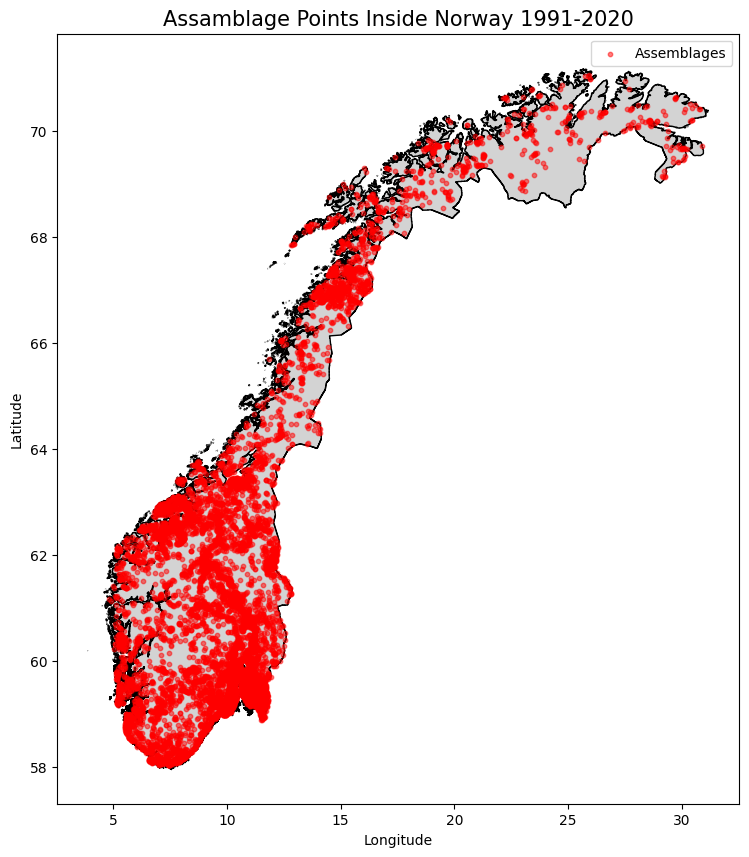

In [15]:
def plot_sample_points(df):
    # Load the shapefile of Norway's boundaries (assuming you have this shapefile)
    norway = gpd.read_file("Norway_shapefile\\gadm41_NOR_0.shp").to_crs(epsg=4326)  # Make sure it's in EPSG:4326 for plotting
    
    # Step 2: Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the Norway boundary
    norway.plot(ax=ax, color="lightgray", edgecolor="black")
    
    # Assuming 'result' DataFrame has columns 'longitude' and 'latitude' (from the grid centroids)
    result_geo_df = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"  # Ensure the correct CRS
    )
    
    # Plot the filtered points inside Norway
    result_geo_df.plot(ax=ax, markersize=10, color='red', alpha=0.5, label="Assemblages")
    
    # Customize plot
    ax.set_title("Assamblage Points Inside Norway 1991-2020", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    
    # Show the plot
    plt.show()

plot_sample_points(df_sampled)


### Create data loader

In [16]:
train_df, temp_df = train_test_split(df_sampled, test_size=0.3, random_state=42)

# Now, split the temporary data into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ClimaticDataset(Dataset):
    def __init__(self, df):
        self.data = torch.tensor(np.stack(df['climatic_map'].values).astype(np.float32))#.to(device)  # Move data to GPU
        self.labels = torch.tensor(np.stack(df['encoded_lists'].values).astype(np.float32))#.to(device)  # Move labels to GPU

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx].permute(2, 0, 1).to(device)  # Reshape to (C, H, W)
        label = self.labels[idx].to(device)  # Labels already on GPU
        return sample, label


In [20]:
# Create dataset
train_dataset = ClimaticDataset(train_df)
validation_dataset = ClimaticDataset(val_df)
test_dataset = ClimaticDataset(test_df)

ValueError: all input arrays must have the same shape

In [74]:
# Create DataLoader
train_data = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)  # No need for pin_memory here
validation_data = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=0)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
# Example usage
for batch in train_data:
    images, targets = batch
    print(images.shape)  # Should be (batch_size, 11, 16, 16)
    print(targets.shape)  # Should be (batch_size, num_classes)
    # To print the tensor values
    print("Sample image tensor (first image):", images[0])  # Print first image tensor in the batch
    print("Sample target (first label):", targets[0])  # Print first label in the batch
    break  # Stop after first batch

torch.Size([32, 11, 16, 16])
torch.Size([32, 5357])
Sample image tensor (first image): tensor([[[0.0636, 0.0918, 0.0950,  ..., 0.2385, 0.2436, 0.2534],
         [0.1298, 0.1458, 0.2174,  ..., 0.2118, 0.2532, 0.2646],
         [0.2291, 0.2054, 0.3047,  ..., 0.2178, 0.2199, 0.2371],
         ...,
         [0.8642, 0.8790, 0.8757,  ..., 0.9897, 0.9561, 0.8904],
         [0.4612, 0.5148, 0.5106,  ..., 0.9808, 0.9953, 1.0000],
         [0.4280, 0.4382, 0.4176,  ..., 0.7490, 0.8496, 0.9078]],

        [[0.8347, 0.8448, 0.8634,  ..., 0.9039, 0.9068, 0.9023],
         [0.7616, 0.7811, 0.7585,  ..., 0.8864, 0.8722, 0.8699],
         [0.6565, 0.6940, 0.6647,  ..., 0.8323, 0.8445, 0.8414],
         ...,
         [0.0559, 0.0512, 0.0503,  ..., 0.0792, 0.0961, 0.1250],
         [0.2076, 0.2002, 0.2056,  ..., 0.1011, 0.0914, 0.0878],
         [0.2769, 0.2870, 0.3025,  ..., 0.2036, 0.1595, 0.1293]],

        [[0.8415, 0.8521, 0.8710,  ..., 0.8972, 0.8973, 0.8891],
         [0.7625, 0.7831, 0.7608,  .

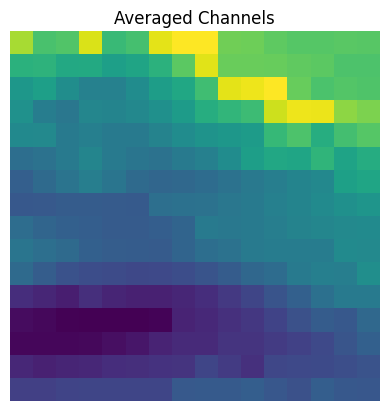

In [75]:
# Assuming `dataloader` is your DataLoader and it's already defined
# Get the first batch of data
data_iter = iter(train_data)
images, labels = next(data_iter)

# Get the first image (assuming the batch size is >= 1)
image = images[0].cpu().numpy()  # Move the image to CPU and convert to numpy

# Plotting the image
# Since the image is in (C, H, W) format, we need to reorder it to (H, W, C) for display
image = image.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
# Average across channels to create a single image
image_avg = image.mean(axis=-1)  # Average along the last axis (channels)

# Plotting the average image
plt.imshow(image_avg, cmap='viridis')  # You can change the colormap
plt.title('Averaged Channels')
plt.axis('off')
plt.show()


In [76]:
df_sampled.iloc[0].climatic_map.shape,df_sampled.iloc[0].climatic_map

((16, 16, 11),
 array([[[0.6414728 , 0.3201623 , 0.3078003 , ..., 0.2821865 ,
          0.38157895, 0.35390946],
         [1.        , 0.20335722, 0.18110466, ..., 0.26895332,
          0.        , 0.        ],
         [0.99051714, 0.19211388, 0.17216492, ..., 0.25068092,
          0.        , 0.00823045],
         ...,
         [0.80588484, 0.17081022, 0.1755681 , ..., 0.11015129,
          0.0131579 , 0.17695473],
         [0.75986624, 0.20123386, 0.21028233, ..., 0.10580444,
          0.3289474 , 0.22222221],
         [0.94840336, 0.15621519, 0.16068411, ..., 0.1030674 ,
          0.        , 0.03703704]],
 
        [[0.94505644, 0.18867493, 0.16649246, ..., 0.26039505,
          0.3157895 , 0.05349794],
         [0.9464507 , 0.17367506, 0.15351439, ..., 0.24141121,
          0.3157895 , 0.04938272],
         [0.9514713 , 0.16223907, 0.1448927 , ..., 0.22022057,
          0.        , 0.04115226],
         ...,
         [0.7865014 , 0.14880133, 0.15619183, ..., 0.08351326,
         

In [77]:
stacking_test = np.stack(df_sampled.iloc[0]['climatic_map']).astype(np.float32)

In [78]:
stacking_test.shape,stacking_test

((16, 16, 11),
 array([[[0.6414728 , 0.3201623 , 0.3078003 , ..., 0.2821865 ,
          0.38157895, 0.35390946],
         [1.        , 0.20335722, 0.18110466, ..., 0.26895332,
          0.        , 0.        ],
         [0.99051714, 0.19211388, 0.17216492, ..., 0.25068092,
          0.        , 0.00823045],
         ...,
         [0.80588484, 0.17081022, 0.1755681 , ..., 0.11015129,
          0.0131579 , 0.17695473],
         [0.75986624, 0.20123386, 0.21028233, ..., 0.10580444,
          0.3289474 , 0.22222221],
         [0.94840336, 0.15621519, 0.16068411, ..., 0.1030674 ,
          0.        , 0.03703704]],
 
        [[0.94505644, 0.18867493, 0.16649246, ..., 0.26039505,
          0.3157895 , 0.05349794],
         [0.9464507 , 0.17367506, 0.15351439, ..., 0.24141121,
          0.3157895 , 0.04938272],
         [0.9514713 , 0.16223907, 0.1448927 , ..., 0.22022057,
          0.        , 0.04115226],
         ...,
         [0.7865014 , 0.14880133, 0.15619183, ..., 0.08351326,
         

In [79]:
stacking_test_2 = np.stack(df_sampled.iloc[0]['species_vector']).astype(np.float32)

In [80]:
stacking_test_2.shape,stacking_test_2

((5357,), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

### Model 0

In [114]:

# Define the CNN model
class ClimaticCNN(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ClimaticCNN, self).__init__()

        # Convolutional layers with ReLU activation and MaxPooling
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layers after flattening
        self.fc1 = nn.Linear(128 * 2 * 2, 512)  # Adjust according to the final feature map size
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Apply the layers sequentially
        x = self.pool(torch.relu(self.conv1(x)))
        # print(f'After conv1 and pool: {x.shape}')
        x = self.pool(torch.relu(self.conv2(x)))
        # print(f'After conv2 and pool: {x.shape}')
        x = self.pool(torch.relu(self.conv3(x)))
        # print(f'After conv3 and pool: {x.shape}')
        # print(x.view(x.size(0),-1).shape)
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0),-1)  # Flatten, adjust the size if needed
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Instantiate the model
num_channels = 11  # Number of channels in your input data
num_classes = len(df.iloc[0].species_vector)  # Adjust based on your dataset (number of species or classes)
model = ClimaticCNN(num_channels, num_classes)

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)


ClimaticCNN(
  (conv1): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5357, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [133]:



#weights = torch.full((num_classes,), 10.0).to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss (adjust depending on your labels)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10  # Number of training epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch in train_data:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # print("Output shape:", outputs.shape)
        # print("Labels shape:", labels.shape)
        # Calculate the loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate accuracy per sample (binary accuracy per label)
    predicted = torch.sigmoid(outputs) > 0.5  # Thresholding the sigmoid output
    print(torch.sigmoid(outputs))
    print(predicted)
    correct_predictions = (predicted == labels).sum().item()
    print(correct_predictions)
    accuracy = correct_predictions / (32 * 5357)  # Total number of labels
    print(accuracy)
    total_samples += labels.size(0) * labels.size(1)  # Number of labels in this batch
    # Print statistics
    epoch_loss = running_loss / len(train_data)
    #epoch_accuracy = (correct_predictions / total_samples) * 100

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in validation_data:
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Save the model
# torch.save(model.state_dict(), 'climatic_cnn.pth')


tensor([[8.4863e-06, 8.5393e-02, 6.2069e-06,  ..., 8.8861e-07, 8.7279e-06,
         7.3837e-06],
        [6.7218e-09, 3.7949e-03, 7.3155e-09,  ..., 1.4794e-12, 1.1583e-08,
         1.2915e-08],
        [6.6096e-06, 9.2700e-04, 6.0190e-06,  ..., 4.1731e-07, 5.2511e-06,
         5.7900e-06],
        ...,
        [9.0457e-12, 7.1890e-03, 2.7826e-11,  ..., 5.1048e-09, 3.2670e-11,
         9.3620e-12],
        [1.8878e-05, 1.4442e-02, 1.4323e-05,  ..., 6.4012e-06, 1.9278e-05,
         1.7961e-05],
        [3.9817e-06, 3.3182e-04, 4.0257e-06,  ..., 1.4751e-09, 3.4655e-06,
         1.9857e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]

NameError: name 'accuracy_fn' is not defined

In [126]:

# Assuming `model` is your trained model and `input_data` is your test input

# Step 1: Set model to evaluation mode
model.eval()

# Step 2: Prepare input data (ensure it's in the correct shape and type)
# For example, input_data should be a torch tensor of shape [batch_size, channels, height, width]
# Here, we assume `input_data` is a tensor, e.g. input_data = torch.randn(32, 11, 16, 16)

# Step 3: Make predictions (forward pass)
with torch.no_grad():  # Disable gradient computation to save memory and computation
    outputs = model(test)  # Model output is the raw logits

# Step 4: Convert logits to probabilities (for binary classification)
probabilities = torch.sigmoid(outputs)  # Apply sigmoid to convert logits to probabilities

# Step 5: Apply threshold to get binary predictions (for multi-class classification, use softmax)
predicted_classes = (probabilities > 0.5).float()  # For binary classification, threshold at 0.5

# If you have multi-class labels, you can use argmax
# predicted_classes = torch.argmax(probabilities, dim=1)  # For multi-class classification

# Step 6: Print or return the predictions
print(predicted_classes)  # Predicted classes (0 or 1 for each class per instance in the batch)
print(probabilities)  # Probabilities for each class (for binary classification)


TypeError: 'DataLoader' object is not subscriptable